In [1]:
#-----------CONNECT GOOGLE DRIVE---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:

#-------------------PULL DATA FROM DATA SET-------------------------------

batch_size = 32
img_height = 1000
img_width = 750

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/gdrive/MyDrive/modeltraining/Uploads/data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/gdrive/MyDrive/modeltraining/Uploads/data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
num_of_classes = len(class_names)
print(class_names)


Found 2539 files belonging to 2 classes.
Using 2032 files for training.
Found 2539 files belonging to 2 classes.
Using 507 files for validation.
['handwritten', 'typed']


In [ ]:
#------------------BALANCED AND UNIQUE IMAGE SETS--------------------------------
from pprint import pprint

h_count = 0
m_count = 0
doublecross = 0

for letter in val_ds.file_paths: # train_ds.file_paths:
  if letter in train_ds.file_paths:
    doublecross += 1
  if "handwritten" in letter:
    h_count += 1
  elif "typed" in letter:
    m_count += 1

print(h_count)
print(m_count)
print(doublecross)

In [ ]:
#-------------------SAVE TESTING FILES-------------------------------
import shutil
import os

testing_files = vars(val_ds)['file_paths']
testing_destination = "/content/gdrive/MyDrive/modeltraining/Uploads/val_files/h/"

for filename in testing_files:
    shutil.copy(filename, testing_destination)


In [ ]:
#---------------PERFORMANCE-----------------------------------
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class myCallback(tf.keras.callbacks.Callback):
  def stop_training(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("98% accuracy on training")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
#------------------DATA AUGMENTATION (OVERFITTING)--------------------

horizontal_augment = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#-------------------CNN MODEL-------------------------

model = Sequential([
  horizontal_augment,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_of_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
#----------------MODEL TRAINING----------------------------
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

In [ ]:
#------------------SAVE MODEL--------------------------
model.save('/content/gdrive/MyDrive/modeltraining/saved_model/hm_model20')

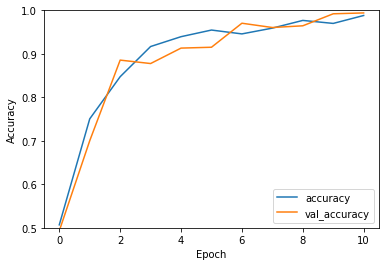

In [ ]:
#----------------ACCURACY VERSUS VALIDATION ACCURACY (VISUALS)----------------------------
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')



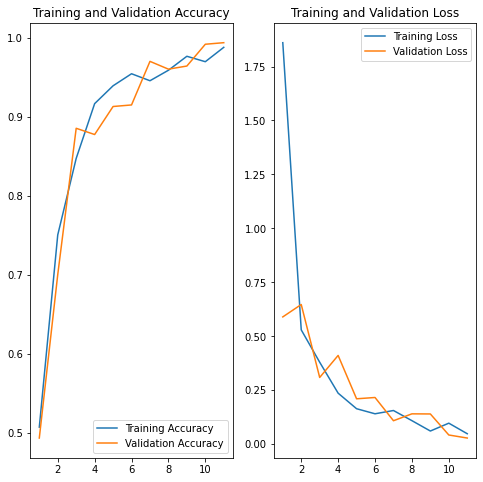

In [ ]:
#-------------ACCURACY AND LOSS (VISUALS)-------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import os

# USED FOR ACCURACY: CONFUSION MATRIX, CLASSIFICATION REPORT
original_labeling = []
class_predictions = []
# USED FOR VALIDATING THE CONFUSION MATRIX
cph = 0
cpt = 0
olh = 0
olt = 0

test_files = os.listdir(testing_destination)

for filename in test_files:
  pathname = testing_destination + filename
  # MAKE PREDICTION
  img_height = 1000
  img_width = 750
  img = tf.keras.utils.load_img(
      pathname, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  class_prediction = class_names[np.argmax(score)]
  class_predictions.append(class_prediction)

  # SAVE ORIGINAL AND PREDICTION VALUES
  if "handwritten" == class_prediction:
    cph += 1  
  elif "typed" == class_prediction:
    cpt += 1
  
  if "h_data" in pathname:
    original_labeling.append("handwritten")
    olh += 1
  elif "t_data" in pathname:
    original_labeling.append("typed")
    olt += 1

# RESULTS (dev debugging)
print("Predictions")
print(cph)
print(cpt)
print("--------------------------------------------------")
print("Actual Values")
print(olh)
print(olt)

In [ ]:
#-------------METRICS-------------------------------------
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

results = sklearn.metrics.confusion_matrix(original_labeling, class_predictions)

chart = ConfusionMatrixDisplay(confusion_matrix=results, display_labels=class_names)

chart.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')
print(classification_report(original_labeling, class_predictions))